In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_1721/3080375706.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')

In [ ]:
set(data['GICS Sector'])

In [11]:
stock_with_
data[['Ticker']].groupby('Ticker').size()

Ticker
A       1259
AAL     1259
AAPL    1259
ABBV    1259
ABNB     768
        ... 
YUM     1259
ZBH     1259
ZBRA    1259
ZION    1259
ZTS     1259
Length: 501, dtype: int64

# Test the data generation scripts

In [3]:
with cProfile.Profile() as pr:
    recorded_info_tb, features_tb, labels_tb = generate_training_data(
        # data=data[data['GICS Sector'].isin(['Information Technology'])],
        data=data,
        training_len=500,
        test_len=120,
        sample_size_per_pair=2
    )

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
# Now you have two options, either print the data or save it as a file
stats.print_stats() # Print The Stats
stats.dump_stats("File/path.prof") # Saves the data in a file, can me used to see the data visually

125250 stock pairs detected
Getting the 1000th pair


KeyboardInterrupt: 

In [ ]:
features_tb

In [ ]:
labels_tb

In [ ]:
recorded_info_tb.to_csv('Data/all_recorded_info_tb.csv', index=False)
features_tb.to_csv('Data/all_features_tb.csv', index=False)
labels_tb.to_csv('Data/all_labels_tb.csv', index=False)

# Draft below

## Get Combinations

In [ ]:
tickers = list(set(data.Ticker))
combinations = list(itertools.combinations(tickers, 2))

In [ ]:
len(combinations)

# Initiate data tables to store the generated results

In [ ]:
recorded_info_tb = pd.DataFrame(columns=[
    'ticker1', 
    'ticker2',
    'target_date',
    'spread',
    'spread_mean',
    'spread_std',
    'abs_spread_mean_l28',
    'abs_spread_std_l28',
    'spread_normed'
])

features_tb = pd.DataFrame(columns=[
    'ticker1', 
    'ticker2',
    'target_date',
    'same_sector_flag',
    'same_sub_industry_flag',
    'cos_sim',
    'corr_coef',
    'abs_spread_normed_max',
    'abs_spread_normed_90th',
    'abs_spread_normed_75th',
    'abs_spread_normed_median',
    'abs_spread_normed_l7_avg',
    'abs_spread_normed_l14_avg'
])

labels_tb = pd.DataFrame(columns=[
    'total_pnl',
    'total_pnl_l28_mean_std'
])

## Generate

In [ ]:
data.head()

In [12]:
ticker1 = 'AMCR'
ticker2 = 'BKNG'

In [13]:
# Get a list of unique dates for later use
all_dates = data['Date'].unique()

In [14]:
# Flag indicating whether the two tickers are from the same sector
same_sector_flag = data[data.Ticker==ticker1]['GICS Sector'].values[0] == data[data.Ticker==ticker2]['GICS Sector'].values[0]
same_sub_industry_flag = data[data.Ticker==ticker1]['GICS Sub-Industry'].values[0] == data[data.Ticker==ticker2]['GICS Sub-Industry'].values[0]

In [15]:
vec1_full = data['Close'][data.Ticker==ticker1].values
vec2_full = data['Close'][data.Ticker==ticker2].values

In [ ]:
# Number of days in the data
num_days_total = len(vec1_full)

In [ ]:
# Keep 500 days for training and 120 days for label calculation
possible_indices_to_sample = list(range(500, num_days_total-119))

In [ ]:
sampled_indices = random.choices(possible_indices_to_sample, k=100)

# Data Set 1

In [ ]:
# for idx in sampled_indices
idx = sampled_indices[0]
print(f"Sampled date is {all_dates[idx]}")
print(f"Dataset1 starts from {all_dates[idx-500]} to {all_dates[idx]}(exclusive)")
print(f"Dataset2 starts from {all_dates[idx]} (inclusive) to {all_dates[idx+120]}")

In [ ]:
# Previous 500 trading days
vec1_sub1 = vec1_full[(idx - 500):idx]
vec2_sub1 = vec2_full[(idx - 500):idx]

# Next 120 trading days
vec1_sub2 = vec1_full[idx:(idx+120)]
vec2_sub2 = vec2_full[idx:(idx+120)]

In [ ]:
len(vec1_sub1)

In [ ]:
# Cosine sim
cos_sim = np.dot(vec1_sub1, vec2_sub1) / (norm(vec1_sub1) * norm(vec2_sub1))

# Correlation coef
corr_coef = np.corrcoef(vec1_sub1, vec2_sub1)[0, 1]

In [ ]:
# Absolute value of the difference of the two stocks
abs_spread = abs(vec1_sub1 - vec2_sub1)
abs_spread_mean = np.mean(abs_spread)
abs_spread_std = np.std(abs_spread)

# Sometimes, historical data might be too strict to get a signal for trade in
abs_spread_mean_l28 = np.mean(abs_spread[-28:])
abs_spread_std_l28 = np.std(abs_spread[-28:])

In [ ]:
# normalize
spread_normed = (abs_spread - abs_spread_mean)/abs_spread_std

In [ ]:
plt.plot(spread_normed)

In [ ]:
# distribution of abs std
## This is to capture when we should expect the reverting to mean to happen for this stock
abs_spread_normed_max = max(abs(spread_normed))
abs_spread_normed_90th = np.percentile(abs(spread_normed),90)
abs_spread_normed_75th = np.percentile(abs(spread_normed),75)
abs_spread_normed_median = np.percentile(abs(spread_normed),50)

# latest 7 day/14 day avg normalized spread
## These could help predict whether a trading signal will appear
abs_spread_normed_l7_avg = abs(np.mean(spread_normed[-7:]))
abs_spread_normed_l14_avg = abs(np.mean(spread_normed[-14:]))

In [ ]:
# Other features to add

In [ ]:
# return the desired feature array

## These are information we record for each iteration for debugging an analysis
recorded_info = [
    ticker1, 
    ticker2,
    all_dates[idx],
    abs_spread,
    abs_spread_mean,
    abs_spread_std,
    abs_spread_mean_l28,
    abs_spread_std_l28,
    spread_normed
]

## There are features that goes into the model (not ticker1, ticker2, the target date, which are used to join the tables)
features = [
    ticker1, 
    ticker2,
    all_dates[idx],
    same_sector_flag,
    same_sub_industry_flag,
    cos_sim,
    corr_coef,
    abs_spread_normed_max,
    abs_spread_normed_90th,
    abs_spread_normed_75th,
    abs_spread_normed_median,
    abs_spread_normed_l7_avg,
    abs_spread_normed_l14_avg
]

In [ ]:
# Append the generated data as new rows to the tables
recorded_info_tb.loc[len(recorded_info_tb)] = recorded_info
features_tb.loc[len(features_tb)] = features

In [ ]:
features_tb

In [ ]:
class ExecutePairTrading:
    def __init__(self, abs_spread_mean, abs_spread_std, entry_signal=1.5, stop_loss=0.2):
        self.abs_spread_mean = abs_spread_mean
        self.abs_spread_std = abs_spread_std
        self.entry_signal=entry_signal
        self.stop_loss=0.2
        
        self.stock1_position=None
        self.stock2_position=None
        self.stock1_long=None
        self.stock1_pl=0
        self.stock2_pl=0
        self.final_pl=0

    def execute(self, vec1, vec2, base_fund=100, split=0.5, verbose=False):
        
        abs_spread = abs(np.array(vec1) - np.array(vec2))

        entry_signal=False
        for i in range(len(abs_spread)):
            # if currently not holding any position
            if self.stock1_position is None:
                
                ## if an entry signal was not generated from the previous trading date
                if not entry_signal:
                    # Check if entry signal appears in the current date
                    if abs_spread[i] >= self.abs_spread_mean + self.entry_signal*self.abs_spread_std:
                        entry_signal=True
                    
                ## If an entry signal was generated from the previous trading date, execute the strategy
                else:
                    self.stock1_position=vec1[i]
                    self.stock2_position=vec2[i]
                    
                    if vec1[i] > vec2[i]:
                        self.stock1_long=False
                        if verbose:
                            print(f"Entered long position at {vec1[i]} for stock1")
                            print(f"Entered short position at {vec2[i]} for stock2")
                    else:
                        self.stock1_long=True
                        if verbose:
                            print(f"Entered short position at {vec1[i]} for stock1")
                            print(f"Entered long position at {vec2[i]} for stock2")

            # if holding a position, check if need to exit and update pnl
            else:
                # calculate pnl
                if self.stock1_long:
                    # calculate pnl when we long stock 1 and short stock 2
                    self.stock1_pl = base_fund * split * ((vec1[i] - self.stock1_position)/self.stock1_position)
                    self.stock2_pl = base_fund * (1-split) * ((self.stock2_position - vec2[i])/self.stock2_position)
                else:
                    # calculate pnl when we long stock 2 and short stock 1
                    self.stock1_pl = base_fund * (self.stock1_position - vec1[i])/self.stock1_position
                    self.stock2_pl = base_fund * (vec2[i] - self.stock2_position)/self.stock2_position    

                # when the absolute spread is less than 0.1 of the std, exit the positions
                ## to-do in the future - this calculation is in-accurate as the exit should be executed the next
                ## trading day, when the pnl would be differentt.
                if abs_spread[i] <= self.abs_spread_mean + 0.1 * self.abs_spread_std:
                    # reset the params
                    entry_signal=False
                    self.stock1_position=None
                    self.stock2_position=None
                    self.stock1_long=None

                    if verbose:
                        print(f"Closed stock1 position at {vec1[i]}. Close stock2 position at {vec2[i]}")
                    # record the pnl from this trade
                    self.final_pl += (self.stock1_pl + self.stock2_pl)
                    self.final_pl_pct = self.final_pl/base_fund

                    if verbose:
                        print(f'Total PnL from this trade is {(self.stock1_pl + self.stock2_pl)}')
                        print(f'cumulative PnL percentage is {self.final_pl/base_fund}')
                    self.stock1_pl=0
                    self.stock2_pl=0
                     

        return self

In [ ]:
trade = execute_spread_trading(
    abs_spread_mean_l28,
    abs_spread_std_l28,
    entry_signal=0.7
)

In [ ]:
trade = trade.execute(
    vec1=vec1_sub2,
    vec2=vec2_sub2
)

trade.final_pl

NameError: name 'idx' is not defined

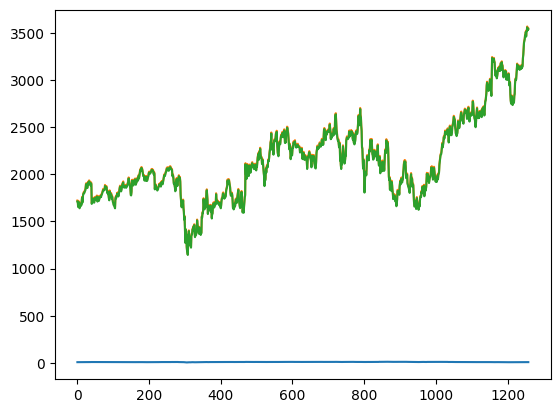

In [16]:
plt.plot(vec1_full, label='Stock1')
plt.plot(vec2_full, label='Stock2')
plt.plot(abs(vec1_full - vec2_full), label='Absolute Spread')
plt.axvline(x=idx, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx-500, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx+120, color='red', linestyle='--', label='Vertical Line')
# plt.plot(abs(vec1_sub2 - vec2_sub2))

# Trading scoring

In [ ]:
abs_spread_mean_l28
abs_spread_std_l28
vec1 = vec1_sub2
vec2 = vec2_sub2

base_fund = 100
split = 0.5

entry_thresh = abs_spread_mean_l28 + 1.5*abs_spread_std_l28
exit_thresh = abs_spread_mean_l28 + 0.1*abs_spread_std_l28

In [ ]:
entry_thresh

In [ ]:
abs_spread = abs(np.array(vec1) - np.array(vec2))

In [ ]:
entry_signals = np.array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0])
exit_signals =  np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1])
# entry_signals = np.array([0]+[1 if abs_spread[i-1] >= entry_thresh else 0 for i in range(1, len(abs_spread))])
# exit_signals = np.array([0]+[1 if abs_spread[i-1] <= exit_thresh else 0 for i in range(1, len(abs_spread))])

In [ ]:
entry_positions = np.where(entry_signals == 1)[0]
exit_positions = np.where(exit_signals == 1)[0]
pairs = []

for entry_pos in entry_positions:
    # Find the first exit position that is greater than the entry position
    next_exit_pos = exit_positions[exit_positions > entry_pos]
    if next_exit_pos.size > 0:
        exit_pos = next_exit_pos[0]
    else:
        # Default exit position if no exit signal is found after the entry signal
        exit_pos = len(entry_signals) - 1
    pairs.append((entry_pos, exit_pos))

In [ ]:
temp_tb = pd.DataFrame(pairs)

In [ ]:
temp_tb.columns = ['entry_idx', 'exit_idx']
temp_tb = temp_tb.groupby('exit_idx').min().reset_index()

In [ ]:
# At each position, calculate each stocks relative pct delta compated to l7. Short the one with larger pct delta
def long_stock1_flag(stock1, stock2, idx):
    """
    This function is to determine which stock to long/short given an entry signal.
    It:
        1. Takes the prices of two stocks, and the position where the entry signal appears 
        2. Calculate the percentage deltas between the current price and the price 7 days ago (or the earliest record) for each stock

    Then we will tell the ago to short the one with higher percentage delta and long the other.

    The function returns a boolean on whether we should long the stock 1.
    """
    stock1_current = stock1[idx]
    stock1_ref = stock1[max(0, idx-7)]

    stock2_current = stock2[idx]
    stock2_ref = stock2[max(0, idx-7)]

    pct_delta_1 = (stock1_current/stock1_ref) - 1
    pct_delta_2 = (stock2_current/stock2_ref) - 1

    if pct_delta_1 >= pct_delta_2:
        return False
    else:
        return True

In [ ]:
temp_tb['stock1_price_entry'] = vec1[temp_tb['entry_idx']] 
temp_tb['stock1_price_exit'] = vec1[temp_tb['exit_idx']] 
temp_tb['stock2_price_entry'] = vec2[temp_tb['entry_idx']] 
temp_tb['stock2_price_exit'] = vec2[temp_tb['exit_idx']] 
temp_tb['long_stock_1'] = [long_stock1_flag(vec1, vec2, x) for x in temp_tb.entry_idx]


pnls = []
for row in range(temp_tb.shape[0]):
    long_pnl=0
    short_pnl=0
    if temp_tb.long_stock_1[row]:
        # calculate pnl when we long stock 1 and short stock 2
        long_pnl = base_fund * split * ((temp_tb.stock1_price_exit.values - temp_tb.stock1_price_entry.values)/temp_tb.stock1_price_entry.values)
        short_pnl = base_fund * (1-split) * ((temp_tb.stock2_price_entry.values - temp_tb.stock2_price_exit.values)/temp_tb.stock2_price_entry.values)
    else:
        # calculate pnl when we long stock 2 and short stock 1
        long_pnl = base_fund * (1-split) * ((temp_tb.stock2_price_exit.values - temp_tb.stock2_price_entry.values)/temp_tb.stock1_price_entry.values)
        short_pnl = base_fund * (split) * ((temp_tb.stock1_price_entry.values - temp_tb.stock1_price_exit.values)/temp_tb.stock2_price_entry.values)
    pnls.append(long_pnl[0]+short_pnl[0])
temp_tb['pnl'] = pnls

In [ ]:
temp_tb

In [ ]:
plt.plot(vec1, label='Stock1', color='red')
plt.plot(vec2, label='Stock2', color='green')
plt.plot(abs(vec1 - vec2), label='Absolute Spread')
plt.axvline(x=48, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=119, color='red', linestyle='--', label='Vertical Line')